# Predicting Saturation Concentration
In this exercise, the gas measurements made at the various locations around Yellowstone and Valles Caldera are examined as time series. After reducing the data into separate chamber enclosures in MATLAB, I import the data into this notebook. 

The goal is to use the data collected from each chamber enclosure and forecast the saturation concentration (i.e., upper asymptote) for each enclosure. This is attempted using a generalized logistic function and the simulation of synthetic concentration-time plots to assess the validity of the forecasts.

After obtaining the saturation concentration, the data can be compared to values colelcted at point sources, and the noble gas geochemistry therein.


## Import Necessary Libraries

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import io

from datetime import datetime

# Import fbprphet for forecasting
from fbprophet import Prophet

## Ingest data into workspace
The ultimate goal is to utilze the Microsoft's `onedrivesdk` package to acces data straight from OneDrive using their [Graph API](https://docs.microsoft.com/en-us/graph/api/overview?view=graph-rest-1.0). This is currently issue #1 in the repo. 

For the time being, data is ingested manually using `files` from the `google.colab` library.

### Programmatically Ingest Data
After mounting Google Colab onto Google Drive, upload the current version of the summary data into workspace. If changes to the summary data have been made since the last use, mount onto Google Drive but manually upload the new version of the file.

In [2]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Point directory towards the correct folder
%cd /content/gdrive/My Drive/Colab Notebooks/caldera-gases

/content/gdrive/My Drive/Colab Notebooks/caldera-gases


#### Google Drive |  Yellowstone - Programmatically Import Data

In [4]:
# Upload Yellowstone Summary Data
df_2018_YC = pd.read_excel("YNP_SummaryData.xlsx", sheet_name="2018", 
                           header=0, parse_dates=True)
# Delete first row that contains secondary data information
df_2018_YC.drop([0], inplace=True)

# Reset index
df_2018_YC.reset_index(drop=True, inplace=True)

In [5]:
# Upload Yellowstone Summary Data
df_2019_YC = pd.read_excel("YNP_SummaryData.xlsx", sheet_name="2019", 
                           header=0, parse_dates=True)
# Delete first row that contains secondary data information
df_2019_YC.drop([0], inplace=True)

# Reset index
df_2019_YC.reset_index(drop=True, inplace=True)

### Manually Ingest Data
If data has been updated externally, manually upload the data into the workspace.

In [ ]:
# Manual File Upload from local drive
from google.colab import files
uploaded = files.upload()

In [ ]:
# Import file into workspace
import io
df_2019_YC = pd.read_excel(io.BytesIO(uploaded['YNP_SummaryData.xlsx']), 
                           sheet_name="2019",
                           header=0)
# Delete first row that contains secondary data information
df_2019_YC.drop([0], inplace=True)

# Reset index
df_2019_YC.reset_index(drop=True, inplace=True)

# Preview data
df_2019_YC.head(10)

## Preprocessing and cleaning
Several cleaning steps are requireed to ensure correct data types, addressing missing data, and other cleaning activities. More information on cleaning processes can be found in `site-differentation.ipynb` located within the GitHub [repo](https://github.com/907Resident/caldera-gas-emissions).

In [6]:
# Assess the data types for the dataframe
df_2018_YC.dtypes

Site_Name                                         object
Group                                             object
Location                                          object
Soil_Classification                               object
Latitude                                          object
Longitude                                         object
Date_of_Measurement                               object
Start_Time_of_Chamber_Enclosure                   object
End_Time_of_Chamber_Enclosure                     object
Duration_of_Total_Chamber_Enclosure               object
Start_Time_Flux                                   object
End_Time_Flux                                     object
CH4_Flux                                          object
LowerBound_CH4_Flux                               object
UpperBound_CH4_Flux                               object
KP_d13CH4_source                                  object
KP_LowerBound_d13CH4_source                       object
KP_UpperBound_d13CH4_source    

In [7]:
def basic_preprocessing(df):
  # Set dictionary for correct data types
  data_types = {"Group":"category", "Location":"object",
                "Soil_Classification":"category", 
                "Latitude":"float64","Longitude":"float64",
                "Date_of_Measurement":"datetime64",
                "Start_Time_of_Chamber_Enclosure":"datetime64",
                "End_Time_of_Chamber_Enclosure":"datetime64",
                "Duration_of_Total_Chamber_Enclosure":"float64",
                "Start_Time_Flux":"datetime64", "End_Time_Flux":"datetime64",
                "CH4_Flux":"float64", "LowerBound_CH4_Flux":"float64",
                "UpperBound_CH4_Flux":"float64", "KP_d13CH4_source":"float64",
                "KP_LowerBound_d13CH4_source":"float64", 
                "KP_UpperBound_d13CH4_source":"float64",
                "d13CH4_source":"float64", "d13CH4_LowerBound_source":"float64",
                "d13CH4_UpperBound_source":"float64", "CO2_Flux":"float64",
                "LowerBound_CO2_Flux":"float64", 
                "UpperBound_CO2_Flux":"float64", 
                "d13CO2_source":"float64",
                "KP_d13CO2_source":"float64", 
                "KP_LowerBound_d13CO2_source":"float64",
                "KP_UpperBound_d13CO2_source":"float64",
                "d13CO2_source":"float64", "d13CO2_LowerBound_source":"float64",
                "d13CO2_UpperBound_source":"float64",
                "Horita_Geothermometer_Temperature_at_Formation":"float64",
                "Ambient_Temperature":"float64",
                "Barometric_Pressure":"float64",
                "Soil_Tempeature_at_Surface":"float64"}
  # Set data types accordingly
  df = df.astype(data_types)
  # Drop unnecessary columns
  df.drop(df.columns[30:33], axis=1, inplace=True)
  df.drop(df.columns[-1], axis=1, inplace=True)

  # Return data frame
  return df


Execute `basic_preprocessing()` to assign the correct data types and get rid of unncessary columns.

In [8]:
# Yellowstone
## 2018
df_2018_YC = basic_preprocessing(df_2018_YC)
## 2019
df_2019_YC = basic_preprocessing(df_2019_YC)

Concatenate the dataframes from each respective campaign together chronologically. After this process there will be two dataframes, one for Yellowstone and the other for Valles.

In [9]:
# Concatenate 2018 & 2019 dataframes for Yellowstone
df_YC_all = pd.concat([df_2018_YC, df_2019_YC], ignore_index=True)

# Preview dataframe dimensions
YNP_all_shape = df_YC_all.shape
print(YNP_all_shape)

(154, 31)


## Upload .MAT file(s) into workspace

In addition to mannually importing a .xlsx file, we will need to import a .mat file (produced in MATLAB). This file will contain several items that will be stored in a dictionary. Use the `loadmat` function from the `scipy.io` package  to extract the .mat file. More details are [here](https://stackoverflow.com/questions/45007081/convert-mat-file-to-pandas-dataframe).

In [10]:
# Import the scipy.io package
import h5py
# Gather the .mat file
dict_GVNT_06Jun2019 = h5py.File("pertinent-data/GVNT_06Jun2019_MATFILE.mat",
                                "r")
dict_GVNT_22Jun2018 = h5py.File("pertinent-data/GVNT_22Jun2018_MATFILE.mat",
                                "r")
dict_GVNT_28Jun2018 = h5py.File("pertinent-data/GVNT_28Jun2018_MATFILE.mat",
                                "r")
# Print the list of items in the .mat file
list(dict_GVNT_06Jun2019.keys())


['#refs#',
 '#subsystem#',
 'GVNT_ChamON',
 'GVNT_ChamON_DateTimes',
 'GVNT_PostBack',
 'GVNT_PostBack_DateTimes',
 'GVNT_PreBack',
 'GVNT_PreBack_DateTimes',
 'lin_flux',
 'lin_mdl',
 'lin_slope']

Create a function `extract_data_from_MAT()` that will extract all of the individual measurements from the selected .MAT file and enter them as separate dataframes in a list,

In [11]:
def extract_data_from_MAT(MAT_file_as_dict, site_code, data_type):
  '''
  This function extracts the data from the .mat file and enters each individual 
  measurement (i.e. chamber enclosure) as a separate dataframe into a list.

  INPUT: 
  - MAT_file_as_dict: dictionary object. This can be acquired by saving a MATLAB
  file as a .MAT, and then reading it into python using h5py

  - site_code: string object. Four letter code indicating the location where the
  measurements were made. See Ajayi dissertation or accompanying MATLAB code for
  details

  - data_type: string object. Allows the user to select the desired data from the 
  .MAT file. Available choices are strictly as follows: 
  "ChamON", "ChamON_DateTimes", "PreBack", "PreBack_DateTimes", 
  "PostBack", "PostBack_DateTimes", "lin_flux", "lin_mdl", and "lin_slope"

  OUTPUT: 
  - dict_dfs: dictionary object. The output of each measurement as a dataframe to
  compile a list of dataframes.
  '''
  # Create empty dictionary of dataframes
  dict_dfs = {}

  # Access the deisred data from the .mat file
  # .mat file
  if (data_type.__contains__("ChamON") == True) or (data_type.__contains__("PreBack") == True) or (data_type.__contains__("PostBack") == True):
    site_tag = "%s_%s" % (site_code, data_type)

    # Establish the number of chamber enclosures
    nchams = len(MAT_file_as_dict[site_tag])

    # Loop through the .MAT file to get each as a seperate dataframe
    for i in range(nchams):
      # Convert the first chamber enclosure to a dataframe and be sure to 
      # transpose it to the correct dimensions
      df = pd.DataFrame(MAT_file_as_dict[site_tag][i]).T
      # Add column names with list
      col_names = ["date", "elapsed_sec", "CH4_dry", "CH4", "d13_CH4", 
                   "d13_CH4_HR", "CO2_dry", "d13_CO2", "alarm", "CH4_cgs", 
                   "CO2_cgs"]
      # Substitute in the new column names
      df.columns = col_names
      # Change the date column to the correct timestamps
      df["date"] = pd.to_datetime(df["date"]-719529, unit='D')
      # Drop rows that are NaN or NaT
      df.dropna(how="all", inplace=True)
      # Reset index
      df.reset_index(drop=True, inplace=True)
      # Add the dataframe to the output dictionary
      dict_dfs[i] = df
  elif data_type.__contains__("lin_flux"):
    site_tag = data_type
    # Establish the number of chamber enclosures
    nchams = len(MAT_file_as_dict[site_tag])
    # Loop through the .MAT file to get each as a seperate dataframe
    for i in range(nchams):
      if i == 0:
        key = "CH4"
      elif i == 1:
        key = "CO2"
      else:
        key = "key_na"
      # Convert the first chamber enclosure to a dataframe and be sure to 
      # transpose it to the correct dimensions
      df = pd.DataFrame(MAT_file_as_dict[site_tag][i]).T
      # Add column names with list
      col_names = ["Flux_mg_m2_hour1"]
      # Substitute in the new column names
      df.columns = col_names
      # Add the dataframe to the output dictionary
      dict_dfs[key] = df
  else:
    site_tag = data_type
    # Establish the number of chamber enclosures
    nchams = len(MAT_file_as_dict[site_tag])
    # Loop through the .MAT file to get each as a seperate dataframe
    for i in range(nchams):
      # Convert the first chamber enclosure to a dataframe and be sure to 
      # transpose it to the correct dimensions
      df = pd.DataFrame(MAT_file_as_dict[site_tag][i]).T      
      # Add the dataframe to the output dictionary
      dict_dfs[i] = df       

  # Return the final result
  return dict_dfs

Apply `extract_data_from_MAT()` to data from .MAT file(s)

In [12]:
# Extract data 
## Establish site code
site_code = "GVNT"
dict_dfs = extract_data_from_MAT(dict_GVNT_06Jun2019, site_code=site_code, 
                                 data_type="ChamON")
dict_dfs2= extract_data_from_MAT(dict_GVNT_22Jun2018, site_code=site_code, 
                                 data_type="ChamON")
dict_dfs3= extract_data_from_MAT(dict_GVNT_28Jun2018, site_code=site_code, 
                                 data_type="ChamON")
# Combine dictionaries into a list
cmb_dict_dfs = [dict_dfs,dict_dfs3,dict_dfs2]
# Preview the last available dataframe
print(cmb_dict_dfs)

[{0:                              date  elapsed_sec  ...   CH4_cgs     CO2_cgs
0   2019-06-06 11:15:48.000038400        0.000  ...  1.082337  673.616068
1   2019-06-06 11:15:51.000019200        3.515  ...  1.081633  672.295149
2   2019-06-06 11:15:54.999993600        6.988  ...  1.081288  671.296924
3   2019-06-06 11:15:57.999974400       10.468  ...  1.082077  671.462518
4   2019-06-06 11:16:02.000035200       13.946  ...  1.083613  673.308290
..                            ...          ...  ...       ...         ...
300 2019-06-06 11:33:13.000003200     1045.533  ...  1.066627  766.013415
301 2019-06-06 11:33:16.999977600     1049.001  ...  1.067009  766.311339
302 2019-06-06 11:33:19.999958400     1052.451  ...  1.066824  765.599975
303 2019-06-06 11:33:24.000019200     1055.980  ...  1.066761  764.443824
304 2019-06-06 11:33:27.000000000     1059.465  ...  1.066583  764.317306

[305 rows x 11 columns], 1:                              date  elapsed_sec  ...   CH4_cgs      CO2_cgs
0  

Extract the flux data from the .MAT file(s) using `extract_data_from_MAT()`

In [13]:
lin_flux = extract_data_from_MAT(dict_GVNT_06Jun2019, "GVNT", "lin_flux")
print(lin_flux["CH4"])
print(lin_flux["CO2"])

   Flux_mg_m2_hour1
0         -0.011809
1          0.204133
2          1.601747
3          8.126411
4          3.377927
5          0.013987
6          0.030534
   Flux_mg_m2_hour1
0         51.220229
1       1661.767742
2       3125.898900
3      12939.602290
4       4711.169772
5        343.367040
6        110.851310


### Inspect data from MAT file
Plot all of the CH<sub>4</sub> to ensure that the data will be usable for this exercise.

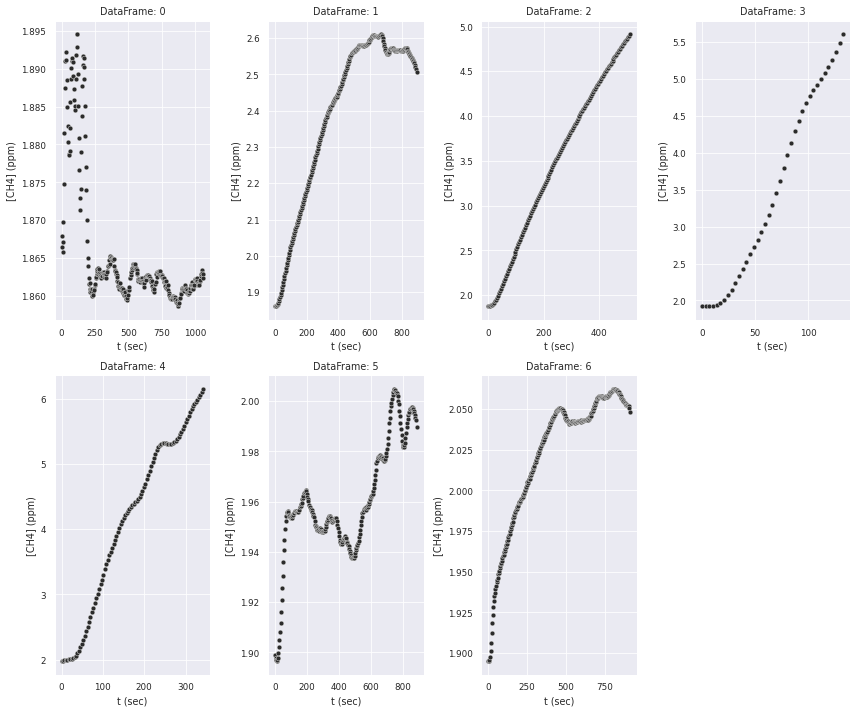

<Figure size 432x288 with 0 Axes>

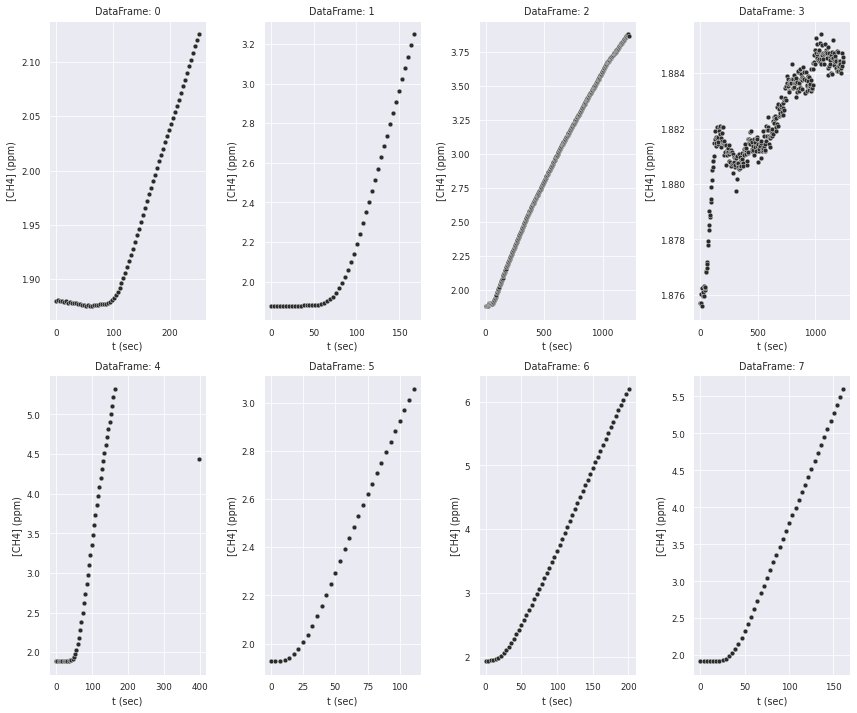

<Figure size 432x288 with 0 Axes>

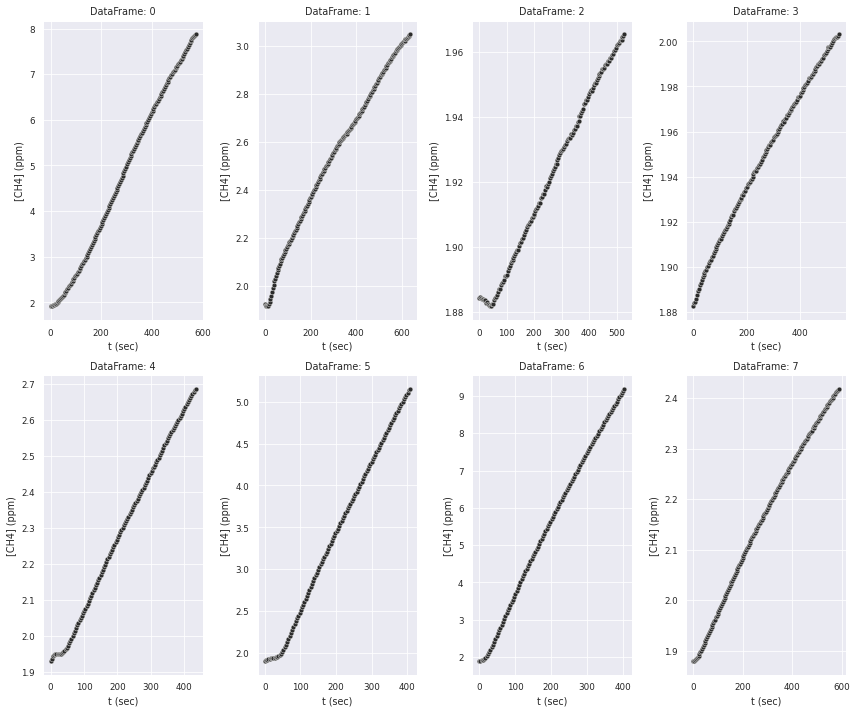

<Figure size 432x288 with 0 Axes>

In [14]:
# Establish plotting style
sns.set_theme(context="paper", style="darkgrid", palette="Greys_r")
for i in range(len(cmb_dict_dfs)):
  d_dfs = cmb_dict_dfs[i]
  # Number of columns in figure
  num_cols = 4
  # Number of rows in figure
  num_rows = math.ceil(len(d_dfs) / num_cols) 
  # Establish figure
  plt.figure(figsize=(12, 10))
  # Loop through each dataframe in the dictionary
  for j, (k, v) in enumerate(d_dfs.items(), 1):
      plt.subplot(num_rows, num_cols, j)
      p = sns.scatterplot(data=v, x='elapsed_sec', y='CH4')
      plt.ylabel("[CH4] (ppm)")
      plt.xlabel("t (sec)")
      plt.title(f'DataFrame: {k}')

  # Visualize   
  plt.tight_layout()
  plt.show()
  site_tag = "figures/%s_CH4_v_time_%d.png" % (site_code, i)
  plt.savefig(site_tag, dpi=300)

Examining the GVNT data from 06 Jun 2019, it is clear that chamber enclosures 0 and 5 will be problematic in attempting to model with a logistic function. These will be omitted from the exercise.

## Curve Fitting with Observed Data
To access the saturation curve, the observed data needs to be fit with a function that will permit simulation of timeseries for the enclosure.

From previous experience and viewing some plots of the data in MATLAB, it is likely that the data will be properly explained by a [generalized logistic function](https://en.wikipedia.org/wiki/Generalised_logistic_function). 

This function comes in the form of:
$y(t) = L + \frac{U - L}{(1 \, + \, y_0 \, e^{-k(t-t_0)})^{\frac{1}{v}}}$, where:
- $y$: the response or [CH<sub>4</sub>] or [CO<sub>2</sub>] (ppm)
- $t$: time (seconds)
- $t_0$: turning point (seconds)
- $L$: lower asymptote (ppm)
- $U$: upper astmptote (ppm)
- $k$: growth rate
- $v$: this value is greater than zero and affects if the asymptote is near the $U$ or near $L$

### Estimate the parameters with observed data
For valid concentration-time curves, estimate the parameters that will describe the relationship between the concentration of gases ([CH<sub>4</sub>] and [CO<sub>2</sub>]) and time. Importantly this fitting process will estimate the upper asymptote parameter, $U$, which will determine the forecasted saturation concentration. 


Due to the fact that the generalized logistic function is nonlinear, the parameters are estimated through a curve-fitting procedure that adopts the least-squares method. This method optimizes the for parameters in the objective function by minimizing the sum of squares in the residuals.  

### Scipy - `curve_fit()`
One method to accomplish this intial fitting is to use the `curve_fit()` function from the Scipy module. These steps are outlined below. Though the results are reasonable, this module does not easily communicate uncertainty for the parameters.

#### Generalized Logistic Function
All of the observed data is fitted with the function above using `curve_fit()` from the SciPy Optimization API. However, note that enlcosures (0,0), (0,5), and (1,3) are omitted from this process because they do not follow traditional concentration-time curves (see Supplemental Figure ## for all observed data). 

In [91]:
from scipy.optimize import curve_fit
from datetime import datetime

# Time the length of the execution
srt_time = datetime.now()
# Define the objective function in python
def gen_logit(t, t0, y0, L, U, k, v):
  return L + (U - L) / ( 1 + np.exp(-k*(t - t0))**(1/v) )

# Data frame containing
df_params_gl = pd.DataFrame(columns=["site_code", "enclosure",
                                     "t0", "y0", "L", "U", "k", "v"])

# Create dictionary of appropriate datatypes
data_types = {"site_code":"str","t0":np.float32, "y0":np.float32,
              "L":np.float32, "U":np.float32, "k":np.float32,
              "v":np.float32}
# Assert correct datatypes 
df_params_gl = df_params_gl.astype(data_types)

for i in range(len(cmb_dict_dfs)):
  # Gather data from each sublist of dataframes
  d_dfs = cmb_dict_dfs[i]  
  data = pd.DataFrame(columns=["site_code", "enclosure", 
                               "t0", "y0", "L","U", "k", "v"],
                      index=range(len(dict_dfs)+len(dict_dfs2)))
  # Loop through the sublist of dataframes and add the parameters to the
  # parameter dataframe
  for j in range(len(d_dfs)):
    # Conditional to skip bad time series
    if i == 0 and (j == 0 or j == 5):
      print("skipped")
      continue
    elif i == 1 and j == 3:
      print("skipped")
      continue
    else:
      # Extract the data as t and y
      t = d_dfs[j].elapsed_sec
      y = d_dfs[j].CH4

      # Fit a logistic curve to the observed data
      bounds = ([     0,      0,  0,      0, -np.inf,-np.inf], 
                [np.inf, np.inf,  5, np.inf,  np.inf, np.inf])
      try:
        params = curve_fit(gen_logit, t, y, bounds=bounds, maxfev=3500)
      except RuntimeError:
        print("Error - maxed out number of iterations to make convergence")
        continue
      # Extract parameters from fit
      t0, y0, L,  U, k, v = params[0]
      # Assign parameters to dataframe
      ## site_code
      data["site_code"].iloc[j] = site_code
      ## enclosure
      data["enclosure"].iloc[j] = (i,j)
      ## t0
      data["t0"].iloc[j] = t0
      ## y0
      data["y0"].iloc[j] = y0
      ## L
      data["L"].iloc[j] = L
      ## U
      data["U"].iloc[j] = U
      ## k
      data["k"].iloc[j] = k
      ## v
      data["v"].iloc[j] = v
  # Append completed dataframe      
  df_params_gl = pd.concat([df_params_gl, data], ignore_index=True)
  # Drop empty rows
  df_params_gl.dropna(inplace=True)

end_time = datetime.now()
print("\nExecution time: %s" % (end_time - srt_time))
# Reset Index
df_params_gl.reset_index(drop=True, inplace=True)
# Change the numeric data types 
df_params_gl = df_params_gl.infer_objects()
# Add in a column that shows the difference between U and L
df_params_gl["diff_U_L"] = df_params_gl.U - df_params_gl.L
# View dataframe of parameters 
df_params_gl

skipped


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning:

overflow encountered in exp



skipped


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning:

overflow encountered in exp



skipped


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning:

overflow encountered in exp



Error - maxed out number of iterations to make convergence

Execution time: 0:02:14.062564


,site_code,enclosure,t0,y0,L,U,k,v
0,GVNT,"(0, 1)",1.897467e+02,1.000000,1.741545e+00,2.586665e+00,0.012815,1.437274
1,GVNT,"(0, 2)",1.455412e+02,1.000000,4.278401e-28,5.623917e+00,0.005643,1.120192
2,GVNT,"(0, 3)",7.601670e+01,0.999987,1.682875e+00,5.835374e+00,2.407234,57.598739
3,GVNT,"(0, 4)",9.855436e+01,1.000001,1.363254e-02,6.417102e+00,0.535327,52.002789
4,GVNT,"(0, 6)",8.685707e-07,0.999964,1.765042e+00,2.055795e+00,0.905914,137.339945
5,GVNT,"(1, 0)",1.813636e+02,1.000000,1.871125e+00,2.142061e+00,-0.009890,-0.321708
6,GVNT,"(1, 1)",1.300934e+02,1.000000,1.853477e+00,3.439494e+00,-0.048819,-1.038857
7,GVNT,"(1, 2)",2.511432e+02,1.000001,4.625391e+00,7.197430e-33,-0.022444,13.321881
8,GVNT,"(1, 4)",1.017464e+02,1.000000,1.829632e+00,5.080905e+00,0.021258,0.402387
9,GVNT,"(1, 5)",6.930099e+01,0.999984,1.783127e+00,3.298666e+00,0.210355,5.650079


Quick visualization of the $U$ paramter 

In [96]:
from scipy.stats import gamma
params_L = gamma.fit(df_params_gl.L)
params_L

(3.3768511626509214, -0.5550548352014351, 0.579351789246704)

Mean diff(U-L): 2.85



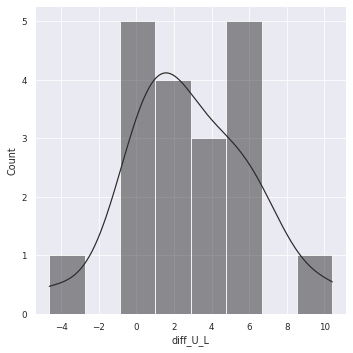

Minimum L: 0.00



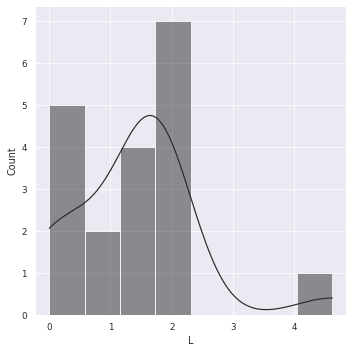

Maximum U: 10.42



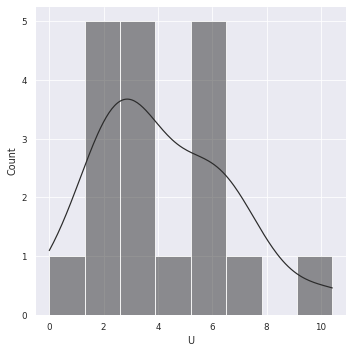

In [231]:
from scipy.stats import gamma

## diff_U_L
print("Mean diff(U-L): %2.2f\n" % df_params_gl.diff_U_L.mean())
sns.displot(x="diff_U_L", data=df_params_gl, bins=8, kde=True)
plt.show()

## L
print("Minimum L: %2.2f\n" % df_params_gl.L.min())
sns.displot(x="L", data=df_params_gl, bins=8, kde=True)
plt.show()

## U
print("Maximum U: %2.2f\n" % df_params_gl.U.max())
sns.displot(x="U", data=df_params_gl, bins=8, kde=True)
plt.show()

Due to the fact that $t_0$, $L$, and $U$ cannot be less than zero in the physical world, these will be considered to originate form a gamma distribution. However, $k$ and $v$ contain negative numbers and will need to be fitted with several distributions to understand the best choice when they are later used to produce synthetic data.

In [228]:
import scipy.stats as sps
def get_best_distribution(data):
  # Create a list of common distributions
  distributions = ["beta", "expon", "f","gamma", "lognorm", "logistic",
                   "maxwell", "norm", "pareto", "pearson3", "rayleigh", 
                   "triang", "uniform", "weibull_min", "weibull_max"]
  # Set up empty lists to stroe results
  chi_square = []
  p_values = []

  # Set up 50 bins for chi-square test
  # Observed data will be approximately evenly distrubuted aross all bins
  percentile_bins = np.linspace(0,100,51)
  percentile_cutoffs = np.percentile(data, percentile_bins)
  observed_frequency, bins = (np.histogram(data, bins=percentile_cutoffs))
  cum_observed_frequency = np.nancumsum(observed_frequency)

  # Loop through candidate distributions

  for dist_name in distributions:
      # Set up distribution and get fitted distribution parameters
      dist = getattr(sps, dist_name)
      param = dist.fit(data)
      
      # Obtain the KS test P statistic, round it to 5 decimal places
      p = sps.kstest(data, dist_name, args=param)[1]
      p = np.around(p, 5)
      p_values.append(p)    
      
      # Get expected counts in percentile bins
      # This is based on a 'cumulative distrubution function' (cdf)
      cdf_fitted = dist.cdf(percentile_cutoffs, *param[:-2], loc=param[-2], 
                            scale=param[-1])
      expected_frequency = []
      for bin in range(len(percentile_bins)-1):
          expected_cdf_area = cdf_fitted[bin+1] - cdf_fitted[bin]
          expected_frequency.append(expected_cdf_area)
      
      # calculate chi-squared
      expected_frequency = np.array(expected_frequency) * len(data)
      cum_expected_frequency = np.nancumsum(expected_frequency)
      ss = np.nansum(((cum_expected_frequency - cum_observed_frequency) ** 2) / cum_observed_frequency)
      chi_square.append(ss)
          
  # Collate results and sort by goodness of fit (best at top)
  results = pd.DataFrame()
  results['Distribution'] = distributions
  results["chi_square"] = chi_square
  results["p_value"] = p_values
  results.sort_values(["chi_square","p_value"], ascending=[False, True],
                      inplace=True)
      
  # Report results
  print ('\nDistributions sorted by goodness of fit:')
  print ('----------------------------------------')
  print (results) 
  return results

In [229]:
# Fit data with theoretical distributions
from sklearn.preprocessing import StandardScaler

# diff(U - L)

# k
## Standardize data - k
sscal = StandardScaler()
## Create dummy array
dmy_k = df_params_gl.k.values.reshape(-1,1)
## Fit and transoform data with scaler
sscal.fit(dmy_k)
scaled_k = sscal.transform(dmy_k)
scaled_k = scaled_k.flatten()
## Delete dummy array
del(dmy_k)
# Obtain best fits
dist_fits_k = get_best_distribution(scaled_k)

# v
## Create dummy array
dmy_v = df_params_gl.v.values.reshape(-1,1)
## Fit and transoform data with scaler
sscal.fit(dmy_v)
scaled_v = sscal.transform(dmy_v)
scaled_v = scaled_v.flatten()
## Delete dummy array
del(dmy_v)
# Obtain best fits
dist_fits_v = get_best_distribution(scaled_v)

/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning:

invalid value encountered in sqrt

/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning:

invalid value encountered in double_scalars




Distributions sorted by goodness of fit:
----------------------------------------
   Distribution  chi_square  p_value
13  weibull_min  369.558500  0.00005
8        pareto  315.303431  0.00026
14  weibull_max  295.975927  0.00000
2             f  281.476671  0.00083
0          beta  229.984984  0.00178
1         expon  228.662169  0.00166
12      uniform   86.768452  0.00392
10     rayleigh   72.172190  0.12018
11       triang   62.425947  0.01210
3         gamma   61.780010  0.09793
9      pearson3   61.779042  0.09793
4       lognorm   61.606470  0.11065
6       maxwell   59.791451  0.06216
7          norm   59.083235  0.04287
5      logistic   52.977598  0.01902


/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning:

invalid value encountered in sqrt

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.

/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning:

invalid value encountered in double_scalars




Distributions sorted by goodness of fit:
----------------------------------------
   Distribution  chi_square  p_value
13  weibull_min  854.179907  0.00000
2             f  540.351889  0.00000
8        pareto  381.103400  0.00007
1         expon  342.575080  0.00006
12      uniform  219.271799  0.00090
10     rayleigh  209.369693  0.00056
6       maxwell  160.932618  0.00205
11       triang  149.764682  0.00245
14  weibull_max  128.299701  0.00135
3         gamma   78.350862  0.02995
4       lognorm   69.727453  0.04226
7          norm   69.324527  0.04312
0          beta   60.412351  0.06990
5      logistic   47.485393  0.09301
9      pearson3   40.625850      NaN


Throught the exercise of fitting over a dozen 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning:

overflow encountered in exp



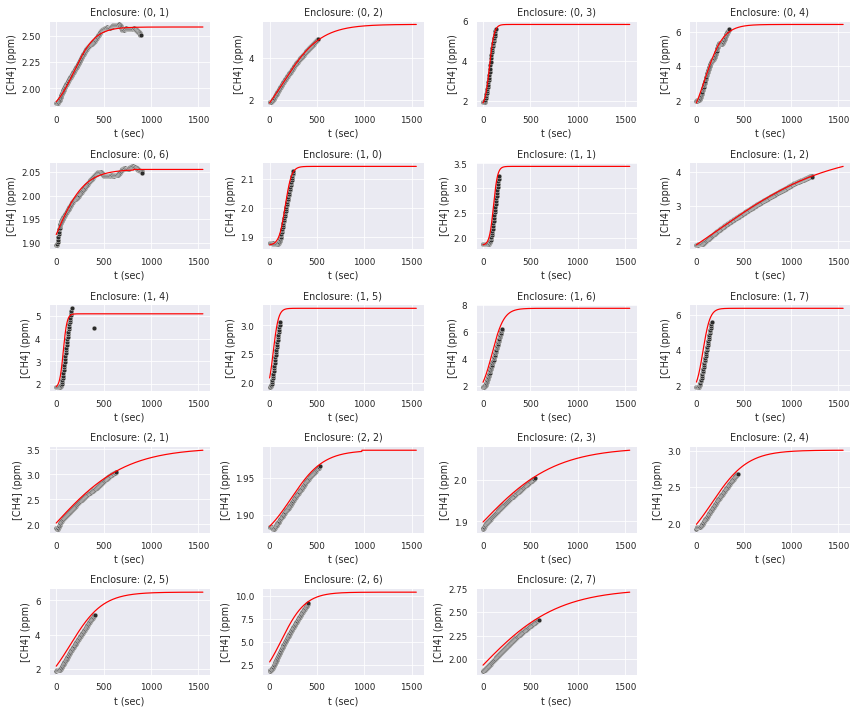

In [87]:
import math

# Number of columns in figure
num_cols = 4
# Number of rows in figure
num_rows = math.ceil(len(df_params_gl) / num_cols)
# Establish figure
plt.figure(figsize=(12, 10))
# Loop through each dataframe in the dictionary
for j, (k, v) in enumerate(df_params_gl.enclosure, 0):
  plt.subplot(num_rows, num_cols, j+1)
  df = cmb_dict_dfs[k][v]
  sns.scatterplot(data=df, x='elapsed_sec', y='CH4')
  plt.plot(np.linspace(t[0], 1550, 2000),
           gen_logit(np.linspace(t[j], 1550, 2000),
                     df_params_gl.t0[j], df_params_gl.y0[j],
                     df_params_gl.L[j], df_params_gl.U[j],
                     df_params_gl.k[j], df_params_gl.v[j]),
           "-r")
  
  plt.ylabel("[CH4] (ppm)")
  plt.xlabel("t (sec)")
  plt.title(f'Enclosure: {k,v}')
  plt.tight_layout()
 
# Save figure  
site_tag = "figures/%s_fitted_gen_logistic-CH4_v_time.png" % site_code
plt.savefig(site_tag, dpi=300)

Calculate the residuals for the curve fit against the observed data. This difference will be used to calculate the noise parameter when generating the synthetic data.

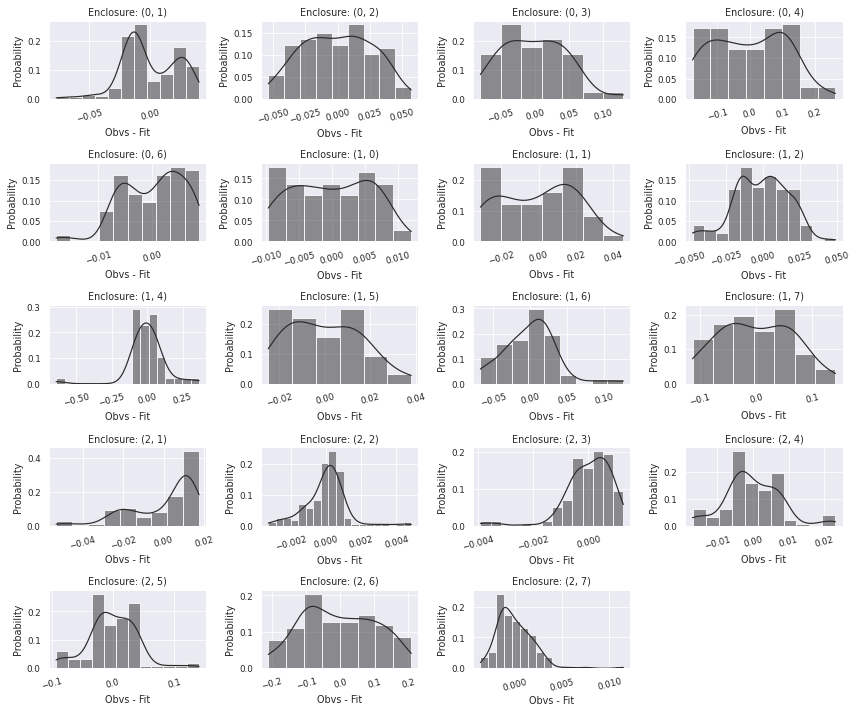

In [88]:
# Create an empty dataframe for residuals for the fits to the observation data
resids_obvs = pd.DataFrame(columns=[df_params_gl.enclosure.to_list()])

# Number of columns in figure
num_cols = 4
# Number of rows in figure
num_rows = math.ceil(len(df_params_gl) / num_cols)
# Establish figure
plt.figure(figsize=(12, 10))
# Loop through each dataframe in the dictionary
for j, (k, v) in enumerate(df_params_gl.enclosure, 0):
  plt.subplot(num_rows, num_cols, j+1)
  # Grab the dataframe from the dictionary of dataframes
  df = cmb_dict_dfs[k][v]
  # Calculate the residuals 
  resids_obvs.iloc[:,j] = \
  df.CH4 - gen_logit(df.elapsed_sec,
                     df_params_gl.t0[j], df_params_gl.y0[j],
                     df_params_gl.L[j], df_params_gl.U[j],
                     df_params_gl.k[j], df_params_gl.v[j])
  # Plot the residuals
  sns.histplot(resids_obvs.iloc[:,j], kde=True, stat="probability")
  plt.xlabel("Obvs - Fit")
  plt.xticks(rotation= 15)
  plt.ylabel("Probability")
  plt.title(f'Enclosure: {k,v}')
  plt.tight_layout()
  plt.savefig("figures/obvs_gl-fit_resids_GVNT_CH4.png", dpi=300)

Figure: Residual values between the observed CH4 data and the optimized general logistic fit.

The residual values between the observation data and the optmized fits are used to parameterize the noise in producing the synthetic data.

In [90]:
# Convert dataframe of residuals into an array
array_resids = resids_obvs.values
# Quantify the mean of non-nan values
mu_noise = np.nanmean(array_resids)
# Quantify the st. deviation of non-nan values
sigma_noise = np.nanstd(array_resids)
# Print values
print("Mean of residuals: %2.3e" % mu_noise)
print("St. Deviation of residuals: %2.3e" % sigma_noise)

Mean of residuals: -3.364e-04
St. Deviation of residuals: 4.287e-02


#### Gompertz Function

In [ ]:
# Define the objective function in python
def gompertz(t, y0, yf, b):
  return y0 * np.exp( np.log(yf/y0) * (1 - np.exp(-b*t)) )

# Data frame containing
df_params_gp = pd.DataFrame(columns=["site_code", "enclosure",
                                     "y0", "yf", "b"])
# Create dictionary of appropriate datatypes
data_types = {"site_code":"str","y0":np.float32, "yf":np.float32,
              "b":np.float32}
# Assert correct datatypes 
df_params_gp = df_params_gp.astype(data_types)  

for i in range(len(cmb_dict_dfs)):
  # Gather data from each sublist of dataframes
  d_dfs = cmb_dict_dfs[i]  
  data = pd.DataFrame(columns=["site_code", "enclosure", 
                               "y0", "yf", "b"],
                      index=range(len(dict_dfs)+len(dict_dfs2)))
  # Loop through the sublist of dataframes and add the parameters to the
  # parameter dataframe
  for j in range(len(d_dfs)):
    # Conditional to skip bad time series
    if i == 0 and (j == 0 or j == 5):
      print("skipped")
      continue
    else:
      # Extract the data as t and y
      t = d_dfs[j].elapsed_sec
      y = d_dfs[j].CH4

      # Fit a logistic curve to the observed data
      bounds = [(1.80, np.NINF, np.NINF), (2.0, np.inf, np.inf)]
      try:
        params = curve_fit(gompertz, t, y, bounds=bounds, maxfev=3500)
      except RuntimeError:
        print("Error - maxed out number of iterations to make convergence")
        continue
      # Extract parameters from fit
      y0, yf, b = params[0]
      # Assign parameters to dataframe
      ## site_code
      data["site_code"].iloc[j] = site_code
      ## enclosure
      data["enclosure"].iloc[j] = (i,j)
      ## y0
      data["y0"].iloc[j] = y0
      ## yf
      data["yf"].iloc[j] = yf
      ## b
      data["b"].iloc[j] = b
  # Append completed dataframe      
  df_params_gp = pd.concat([df_params_gp, data], ignore_index=True)
  # Drop empty rows
  df_params_gp.dropna(inplace=True)

# View dataframe of parameters    
df_params_gp

skipped


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning:

overflow encountered in exp



skipped


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning:

overflow encountered in exp



,site_code,enclosure,y0,yf,b
0,GVNT,"(0, 1)",1.86133,2.39029,7.01263
1,GVNT,"(0, 2)",1.87761,3.49886,6.6418
2,GVNT,"(0, 3)",1.92244,3.53824,6.62179
3,GVNT,"(0, 4)",1.8,7.5316,0.0055066
4,GVNT,"(0, 6)",1.90235,2.05973,0.00466185
5,GVNT,"(1, 0)",1.82006,1.60637e+10,2.38728e-05
6,GVNT,"(1, 1)",1.87674,2.25122,6.863
7,GVNT,"(1, 2)",1.87946,2.94425,6.85727
8,GVNT,"(1, 3)",1.8781,1.88611,0.00135283
9,GVNT,"(1, 4)",1.89264,3.13221,6.78912


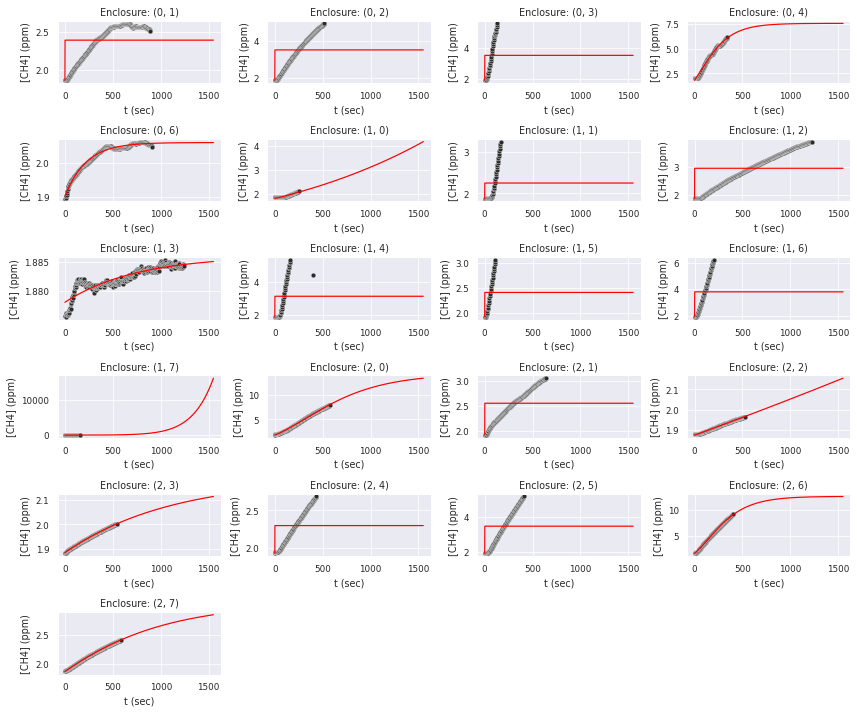

In [ ]:
# Number of columns in figure
num_cols = 4
# Number of rows in figure
num_rows = math.ceil(len(df_params_gp) / num_cols)
# Establish figure
plt.figure(figsize=(12, 10))
# Loop through each dataframe in the dictionary
for j, (k, v) in enumerate(df_params_gp.enclosure, 0):
  plt.subplot(num_rows, num_cols, j+1)
  df = cmb_dict_dfs[k][v]
  sns.scatterplot(data=df, x='elapsed_sec', y='CH4')
  plt.plot(np.linspace(t[0], 1550, 2000),
           gompertz(np.linspace(t[0], 1550, 2000),
                    df_params_gp.y0[j],
                    df_params_gp.yf[j],
                    df_params_gp.b[j]),
           "-r")
  plt.ylabel("[CH4] (ppm)")
  plt.xlabel("t (sec)")
  plt.title(f'Enclosure: {k,v}')
  plt.tight_layout()
  
# Save figure  
site_tag = "figures/%s_fitted_gompertz-CH4_v_time.png" % site_code
plt.savefig(site_tag, dpi=300)

In [ ]:
dict_dfs[2][(dict_dfs[2].elapsed_sec >= 0) & (dict_dfs[2].elapsed_sec <= 5)]

,date,elapsed_sec,CH4_dry,CH4,d13_CH4,d13_CH4_HR,CO2_dry,d13_CO2,alarm,CH4_cgs,CO2_cgs
0,2019-06-06 12:26:56.000025600,0.000,1.849656,1.877614,-44.060339,-44.060339,421.737046,-10.220448,0.0,1.086377,679.496772
1,2019-06-06 12:27:00.000000000,3.491,1.851102,1.879069,-48.032279,-48.032279,421.777091,-10.243013,0.0,1.087226,679.561291


### Curve fitting with `LMFIT`
The module `lmfit` is an extension of what Scipy `curve_fit()` produces.

In [ ]:
# Install the lmfit module
!pip install lmfit

     |████████████████████████████████| 307kB 16.9MB/s 
     |████████████████████████████████| 61kB 5.8MB/s 
     |████████████████████████████████| 256kB 37.7MB/s 
  Created wheel for lmfit: filename=lmfit-1.0.2-cp37-none-any.whl size=85265 sha256=7d47c32f3ca9de76840f87ad5a29644981c8e6c45f0c4e8115249037cf8f6f6f
  Stored in directory: /root/.cache/pip/wheels/d4/5e/db/d9f5987d9f15bf910feb5e0274ac601d5f2161dc78aedfacfa
  Created wheel for asteval: filename=asteval-0.9.23-cp37-none-any.whl size=17419 sha256=dc5345ea19df4c594e5064b5d54f6abd9c269a9291dbe185478c805ca7161cff
  Stored in directory: /root/.cache/pip/wheels/56/d6/43/4b5d8a9fd98b976031768673658c8b8d08dc9dcc0fa1907ad0
Successfully built lmfit asteval


In [ ]:
# Define the objective function in python
def objective(t, t0, y0, L, U, k, v):
  return L + (U - L) / ( 1 + np.exp(-k*(t - t0))**(1/v) )

In [ ]:
from lmfit import Model

# Establish the Model object from lmfit
mdl = Model(objective)
# Establish hints for parameters (i.e. constraints)
mdl.set_param_hint("L", value=1, min=0)
mdl.set_param_hint("U", value=2, min=2.0, max=36)
mdl.set_param_hint("y0", value=1.9817, min=1.7)
mdl.set_param_hint("t0", value=0, min=0)
mdl.set_param_hint("k", value=k)
mdl.set_param_hint("v", value=v)
# Establish parameters
params = mdl.make_params()
# Confirm parameters and independent variable are correct
print("parameter names: {}".format(mdl.param_names))
print("independent variables: {}".format(mdl.independent_vars))

parameter names: ['t0', 'y0', 'L', 'U', 'k', 'v']
independent variables: ['t']


In [ ]:
params

name,value,initial value,min,max,vary
t0,0.00000000,None,0.00000000,inf,True
y0,1.98170000,None,1.70000000,inf,True
L,1.00000000,None,0.00000000,inf,True
U,2.00000000,None,2.00000000,36.0000000,True
k,0.01934610,None,-inf,inf,True
v,0.46290010,None,-inf,inf,True


In [ ]:
# Acquire data
t = dict_dfs[3].elapsed_sec
t = t.astype(np.float32)
y = dict_dfs[3].CH4
y = y.astype(np.float32)

# Fit model to the data
result = mdl.fit(y,params, t=t)

# Print Report
print(result.fit_report())

[[Model]]
    Model(objective)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 207
    # data points      = 39
    # variables        = 6
    chi-square         = 18.599365
    reduced chi-square = 0.56361713
    Akaike info crit   = -16.8769335
    Bayesian info crit = -6.89556366
##  Warning: uncertainties could not be estimated:
    t0:  at boundary
    y0:  at initial value
[[Variables]]
    t0:  0.00000000 (init = 0)
    y0:  1.98170000 (init = 1.9817)
    L:   5.2006e-04 (init = 1)
    U:   4.64419379 (init = 2)
    k:   0.01242714 (init = 0.0193461)
    v:   0.59423326 (init = 0.4629001)


In [ ]:
result.params["value"][]

name,value,initial value,min,max,vary
t0,220.791573,0,-inf,inf,True
y0,1.98170000,1.9817,1.70000000,inf,True
L,1.60000144,1.6,1.60000000,inf,True
U,5.00913156,2,2.00000000,36.0000000,True
k,0.02083704,0.022402779021950224,-inf,inf,True
v,2.33655693,7.248070548580831,-inf,inf,True


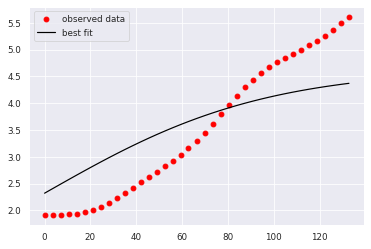

In [ ]:
# Visualize
plt.plot(t, y, "ro", label="observed data")
plt.plot(t, result.best_fit, "k-", label="best fit")
plt.legend()
plt.show()

## Creating Synthetic Data
The observed data only shows upper asymptotes in some of the concentration-time curves. However, the desire for this exercise is to estimate the value or range of possible values for that upper asymptote (i.e., saturation concentration). Though curve fitting provides an estimate of the asymptote, further modeling is required to assess the uncertainty of the initial fits.

Creating simulated or synthetic data is sometimes an excellent method to uncover the uncertainty about diffuclt to measure phenomenon. These techniques have been employed for a myriad of sitauations (Gelman and Hill, 2007) and will be utlized here. 

The first step will be to create the model that will define the synthetic concentration-time curve. The model is shown below and appears very similar to the fuction that fit the observed data. However, there are some exceptions. First, there is an new variable,  noise ($\epsilon$) that will provide random error to the model. $\epsilon$ will be drawn from a normal distribution with a mean ($\mu$) and standard deviation ($\sigma$) equal to the mean and standard deviation of the residuals between the observed data fitted to the curve presented above. Second, a subset of the parameters ($L, U, y_0, k, and v$) will be be drawn from gamma distributions that are parameterized by the results from the observed data. For example, $U \thicksim \Gamma(\kappa, \theta) \thicksim \Gamma(\frac{\mu}{\theta}, \, \sigma \sqrt{\mu})$. \

To generate the synthetic concentration, $\tilde y$, the following function is used:
$\tilde y(t) = L + \frac{U - L}{(1 \, + \, y_0 \, e^{-k(t-t_0)})^{\frac{1}{v}}} + \epsilon$

### Modeling GVNT Synthetic Data

In [ ]:
# Intialize the number of loops that will be made in MC
iter = 10000
# Establish variable for synthetic GVNT data
t_synth = np.arange(0, 1800, 3)
# Establish empty simulated concentration values
y_synth = pd.Series(index=range(len(t_synth)), dtype=np.float32)

Quantify the desriptive stats for the relevant variables. These will be used to parameterize the distribution from which the values will be chosen.

In [128]:
from numpy.random import seed
from numpy.random import normal as rng_norm
# Seed the random number generator
seed_num = 0 
seed(seed_num)
# Set the number of iteratins
iterations = np.int(10E03)

# Objective function for synthetic data
def objective_synth(t, t0, y0, L, U, k, v, epsilon):
  return L + (U - L) / ( 1 + np.exp(-k*(t - t0))**(1/v) ) + epsilon

# Empty dataframe for synthetic parameters
df_params_gl_synth = \
pd.DataFrame(columns=["t0_synth", "y0_synth", "L_synth", 
                      "U_synth", "k_synth",
                      "v_synth", "epsilon_synth"],
             index=range(iterations))
# Set up time in seconds for synthetic data 
t_synth = np.linspace(0, 1200, 600, endpoint=True)
# Establish dataframe to store parametes from MC
df_MC_params_gl = \
pd.DataFrame(columns=["t0_synth_fit", "y0_synth_fit", "L_synth_fit", 
                      "U_synth_fit", "k_synth_fit", "v_synth_fit"])

# Loop through to create synthetic concentration-time curves
for i in range(iterations):
  # UDraw random t0 from observed data
  df_params_gl_synth["t0_synth"].iloc[i] = \
  rng_norm(loc=df_params_gl.t0.mean(),scale=df_params_gl.t0.std(),
             size=1)
  # Draw random y0_synth from normal distribution
  df_params_gl_synth["y0_synth"].iloc[i] = \
  rng_norm(loc=df_params_gl.y0.mean(),scale=df_params_gl.y0.std(),
             size=1)
  # Draw random L_synth from normal distribution
  df_params_gl_synth["L_synth"].iloc[i] = \
  rng_norm(loc=df_params_gl.L.mean(),scale=df_params_gl.L.std(),
             size=1)
  # Draw random U_synth from normal distribution
  df_params_gl_synth["U_synth"].iloc[i] = \
  rng_norm(loc=df_params_gl.U.mean(),scale=df_params_gl.U.std(),
             size=1)
  # Draw random k from from normal distribution
  df_params_gl_synth["k_synth"].iloc[i] = \
  rng_norm(loc=df_params_gl.k.mean(),scale=df_params_gl.k.std(),
             size=1)
  # Draw random k from from normal distribution
  df_params_gl_synth["v_synth"].iloc[i] = \
  rng_norm(loc=df_params_gl.v.mean(),scale=df_params_gl.v.std(),
             size=1)
  # Draw random epsilon_synth from normal distribution
  df_params_gl_synth["epsilon_synth"].iloc[i] = \
  rng_norm(loc=mu_noise,scale=sigma_noise, size=1)  
  # Generate synthetic data
  y_synth = \
  objective_synth \
  (t_synth, 
   df_params_gl_synth.t0_synth.iloc[i], 
   df_params_gl_synth.y0_synth.iloc[i], 
   df_params_gl_synth.L_synth.iloc[i],
   df_params_gl_synth.U_synth.iloc[i],
   df_params_gl_synth.k_synth.iloc[i], 
   df_params_gl_synth.v_synth.iloc[i], 
   df_params_gl_synth.epsilon_synth.iloc[i])
  # data dataframe to hold fresh fitted parameters
  data = \
  pd.DataFrame([], columns=["t0_synth_fit", "y0_synth_fit", "L_synth_fit", 
                            "U_synth_fit", "k_synth_fit", "v_synth_fit"],
               index=range(1))
  # Fit generalized logistic function to synthetic data
  try:
    params = curve_fit(gen_logit, t_synth, y_synth, bounds=bounds,
                       maxfev=3500)
  except RuntimeError:
    print("Error - maxed out number of iterations to make convergence")
    df_MC_params_gl = pd.concat([df_MC_params_gl, data], ignore_index=True)
    continue
  
  # Extract parameters from fit
  t0, y0, L,  U, k, v = params[0]
  # Assign parameters to dataframe
  ## t0
  data["t0_synth_fit"].iloc[0] = t0
  ## y0
  data["y0_synth_fit"].iloc[0] = y0
  ## L
  data["L_synth_fit"].iloc[0] = L
  ## U
  data["U_synth_fit"].iloc[0] = U
  ## k
  data["k_synth_fit"].iloc[0] = k
  ## v
  data["v_synth_fit"].iloc[0] = v
  # Store variables accordingly
  df_MC_params_gl = pd.concat([df_MC_params_gl, data], ignore_index=True)

  # Visualize every 1000 iterations
  if i % 1000 == 0:
    try:
      sns.scatterplot(x=t_synth, y=y_synth)
      plt.plot(np.linspace(t[0], 1800, 600),
               gen_logit(np.linspace(t[0], 1800, 600),
                         df_MC_params_gl.t0_synth_fit[i], 
                         df_MC_params_gl.y0_synth_fit[i],
                         df_MC_params_gl.L_synth_fit[i], 
                         df_MC_params_gl.U_synth_fit[i],
                         df_MC_params_gl.k_synth_fit[i], 
                         df_MC_params_gl.v_synth_fit[i]),
               "-r")
      plt.show()
      print(i)
      del(data)
    except RuntimeError:
      print("Error - could not conduct fit for this iteration")
MC_results_str ="%s_df_MC_params_gl_seed-%d.csv" % (site_code, seed_num)     
df_MC_params_gl.to_csv(MC_results_str, index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning:

divide by zero encountered in power

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning:

divide by zero encountered in power

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning:

overflow encountered in power

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning:

overflow encountered in exp



Error - maxed out number of iterations to make convergence


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning:

overflow encountered in exp



Error - maxed out number of iterations to make convergence


KeyboardInterrupt: ignored

In [ ]:
df_MC_params_gl.to_csv("df_MC_params_gl_seed-13.csv", index=False)

In [ ]:
df_MC_params_gl = df_MC_params_gl.astype("float32")
df_MC_params_gl.head()

,t0_synth_fit,y0_synth_fit,L_synth_fit,U_synth_fit,k_synth_fit,v_synth_fit
0,233.226807,1.0,4.381338,0.091721,1.434672,62.370972
1,126.535233,1.0,6.256478,2.272484,0.216108,8.457464
2,137.010544,1.0,2.499778,-1.728645,1.559680,59.054661
3,-35.016911,1.0,5.289909,8.366714,0.160418,1.531288
4,93.403717,1.0,4.061140,2.456773,0.881083,43.341900


Maximum L: -6.47

Maximum U: 13.32



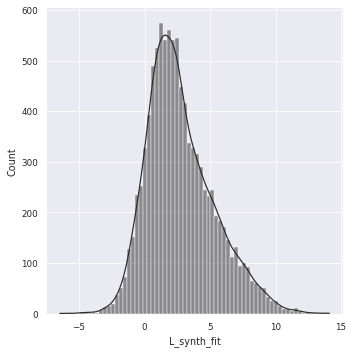

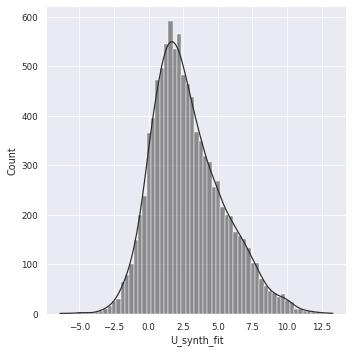

In [ ]:
from scipy.stats import norm

## L
print("Maximum L: %2.2f\n" % df_MC_params_gl.L_synth_fit.min())
sns.displot(x="L_synth_fit", data=df_MC_params_gl, kde=True)

## U
print("Maximum U: %2.2f\n" % df_MC_params_gl.U_synth_fit.max())
sns.displot(x="U_synth_fit", data=df_MC_params_gl, kde=True)
plt.show()

## Logistic Modeling with Facebook Prophet

In [ ]:
df_test = df[["date", "CH4_dry"]]
df_test.dropna(inplace=True)
df_test.set_index("date", inplace=True)
df_test.index = df_test.index.rename("ds")
df_test.index = df_test.index.round("S")
names_Prophet_df = ["y"]
df_test.columns = names_Prophet_df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_test.reset_index(inplace=True)
print(df_test)

                     ds         y
0   2019-06-06 12:26:56  1.849656
1   2019-06-06 12:27:00  1.851102
2   2019-06-06 12:27:03  1.853991
3   2019-06-06 12:27:07  1.858189
4   2019-06-06 12:27:10  1.865596
..                  ...       ...
142 2019-06-06 12:35:15  4.720467
143 2019-06-06 12:35:18  4.735887
144 2019-06-06 12:35:22  4.751378
145 2019-06-06 12:35:25  4.767941
146 2019-06-06 12:35:29  4.783116

[147 rows x 2 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


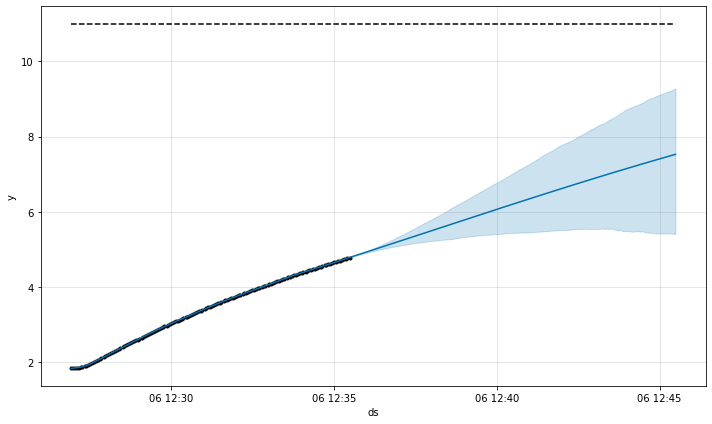

In [ ]:
df_test["cap"] = 11
m = Prophet(growth='logistic')
m.fit(df_test)

# Python
future = m.make_future_dataframe(periods=600, freq="S")
future['cap'] = 11
fcst = m.predict(future)
fig = m.plot(fcst)

In [ ]:
fcst[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'trend_lower', 'trend_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
742,2019-06-06 12:45:25,7.525258,5.869597,9.087022,7.525258,5.868875,9.087526
743,2019-06-06 12:45:26,7.529852,5.867108,9.091355,7.529852,5.867105,9.090712
744,2019-06-06 12:45:27,7.534445,5.865454,9.094828,7.534445,5.865630,9.095935
745,2019-06-06 12:45:28,7.539039,5.868233,9.104108,7.539039,5.865746,9.105300
746,2019-06-06 12:45:29,7.543632,5.867306,9.117160,7.543632,5.865862,9.114707
